In [1]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver, LUSolver

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


In [2]:
function_domain = IntervalDomain(0, 1)
M = L2Space(10, function_domain)
N_d = 50
D = EuclideanSpace(N_d)
N_p = 2
P = EuclideanSpace(N_p)
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=40)
G = SOLAOperator(M, D, normal_modes_provider)
target_provider = BumpFunctionProvider(M)
T = SOLAOperator(M, P, )

<Axes: title={'center': 'Function on [0.0, 1.0]'}, xlabel='x', ylabel='f(x)'>

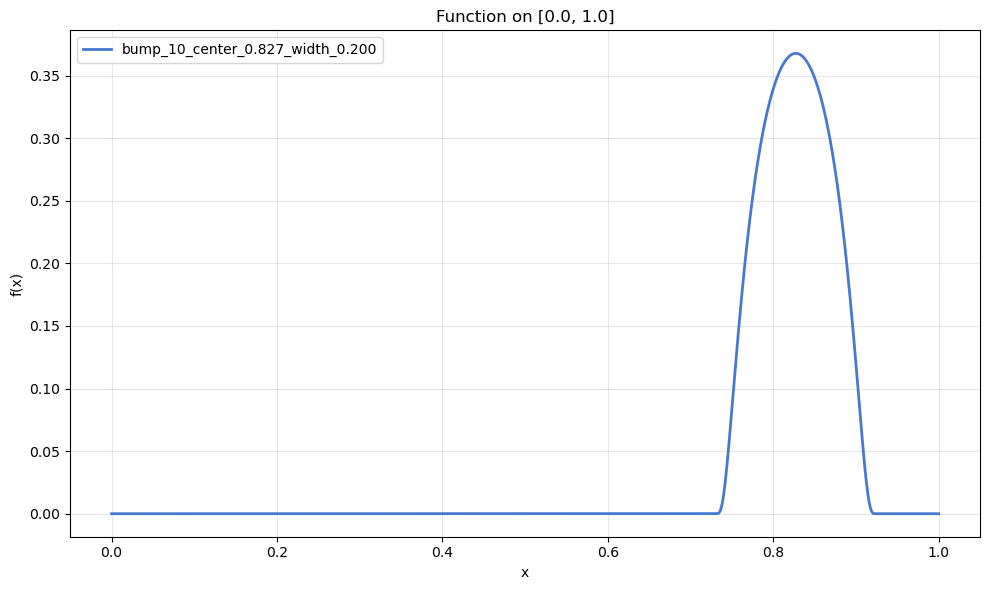

In [20]:
target_provider.get_function_by_index(10).plot()  # First position

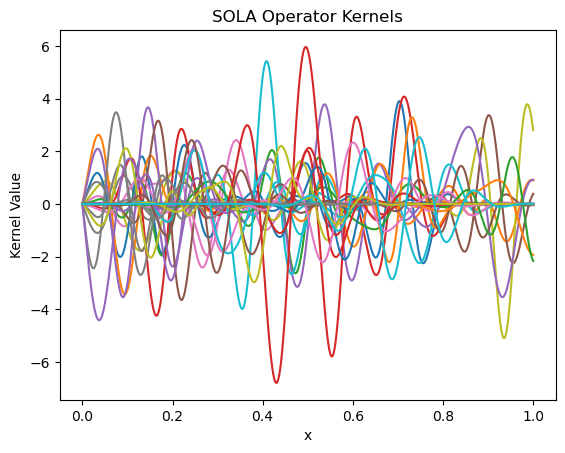

In [11]:
# Plot all the kernels in G
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 1, 1000)
for i in range(N_d):
    plt.plot(x, G.function_provider.get_function_by_index(i).evaluate(x), label=f'Kernel {i}')
plt.title('SOLA Operator Kernels')
plt.xlabel('x')
plt.ylabel('Kernel Value')
plt.show()

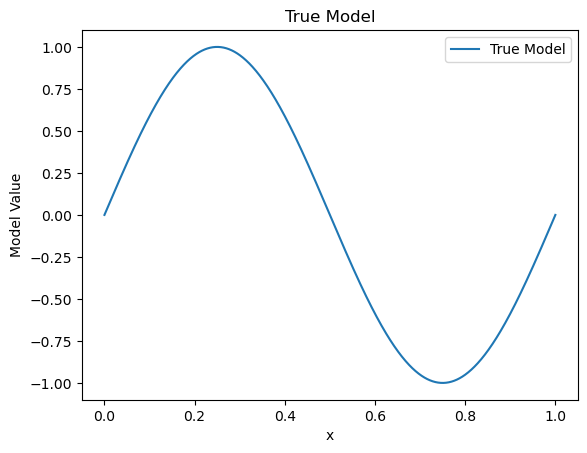

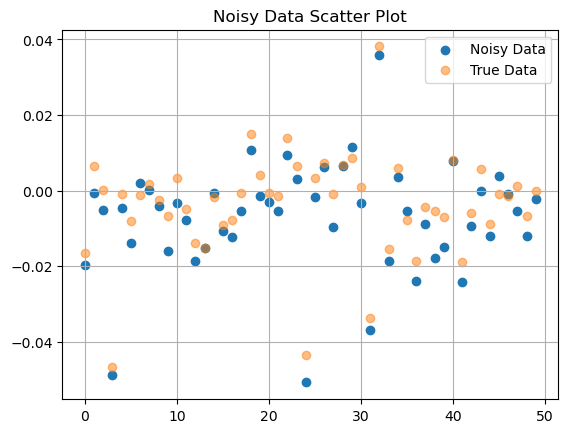

In [12]:
# Create a true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
# Plot the true model
plt.plot(x, m_bar.evaluate(x), label='True Model')
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.show()

# Create corresponding data
d_bar = G(m_bar)
# Create noisy data
d_tilde = d_bar + np.random.normal(-0.1*np.max(d_bar), 0.1*np.max(d_bar), d_bar.shape)

plt.scatter(np.arange(len(d_bar)), d_tilde, label='Noisy Data')
plt.scatter(np.arange(len(d_bar)), d_bar, label='True Data', alpha=0.5)
plt.grid()
plt.title('Noisy Data Scatter Plot')
plt.legend()
plt.show()

In [13]:
# Compute normal operator
lambda_reg = 1e-4  # Regularization parameter
identity = M.identity_operator()
cholesky_solver = CholeskySolver(galerkin=False)
G_normal_reg = cholesky_solver(G @ G.adjoint + lambda_reg * identity)
G_inv_reg = G.adjoint @ G_normal_reg
G_normal = cholesky_solver(G @ G.adjoint)
G_inv = G.adjoint @ G_normal

In [14]:
m_tilde = G_inv(d_bar)
m_tilde_noisy = G_inv(d_tilde)
m_tilde_reg = G_inv_reg(d_tilde)
m_tilde_noisy_reg = G_inv_reg(d_tilde)

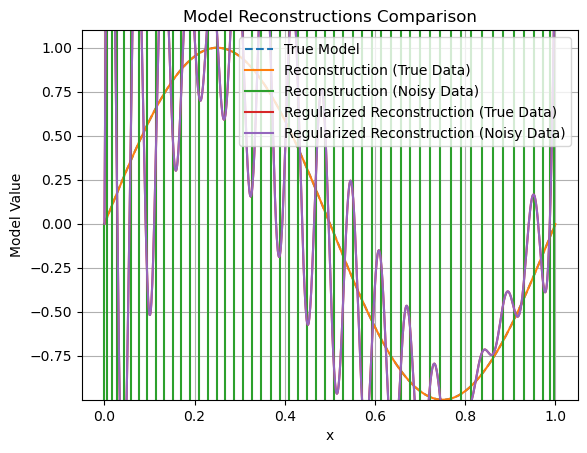

In [15]:
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--')
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (True Data)')
plt.plot(x, m_tilde_noisy.evaluate(x), label='Reconstruction (Noisy Data)')
plt.plot(x, m_tilde_reg.evaluate(x), label='Regularized Reconstruction (True Data)')
plt.plot(x, m_tilde_noisy_reg.evaluate(x), label='Regularized Reconstruction (Noisy Data)')
plt.ylim(np.max(m_bar.evaluate(x)) * -1, np.max(m_bar.evaluate(x)) * 1.1)
plt.title('Model Reconstructions Comparison')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid()
plt.show()
